In [514]:
using PotentialFlow
using Plots
using JLD
using CSV
using MAT

# Load in Data
---

- We should combine the comm_history and the body shape into a single JLD file - this will prevent errors with using the wrong body and vortex position

In [515]:
Δx = 0.12308

# Load in the precomputed community detection data
# -----------------------------------------
d = load("./JLD/comm_hist_gamma_0_75.jld");

ξ_hist  = d["xi_hist"];
xb_hist = d["xb"];
yb_hist = d["yb"];
x̄_hist  = d["x_bar_hist"];
ȳ_hist  = d["y_bar_hist"];
ω_hist  = d["omg_hist"];

# Load in the precomputed bodies
# -----------------------------------------
b_list = load("./JLD/bodies_AoA35_gust_Re100_kb_0.625_3730_4100.jld");

b_list = b_list["b_list"];

# Load in force data
# -----------------------------------------
# a = load("./force_files/gust/2.5/AoA_35_gust_2.5_Kb_0.625.csv");

# force_hist  = a["force_hist"];

# Load in the precomputed community detection data
# -----------------------------------------
fileIn = matopen("./comm_hist_a35_g00_k0625_mg5_limit_new.mat")

# ξ_hist  = d["xi_hist"];
# xb_hist = d["xb"];
# yb_hist = d["yb"];
# x̄_hist  = d["x_bar_hist"];
# ȳ_hist  = d["y_bar_hist"];
# ω_hist  = d["omg_hist"];



ξ_hist = read(fileIn, "xi_hist") 
x̄_hist = read(fileIn, "x_bar_hist") 
ȳ_hist = read(fileIn, "y_bar_hist") 
xb_hist = read(fileIn, "xb") 
yb_hist = read(fileIn, "yb") 
ω_hist  = read(fileIn, "omg_hist");

# Potential Flow Functions
---

In [516]:
function compute_ẋ!(ẋ, x, t)
    body, ambient_sys = x
    motion = ẋ[1]
    # update the instantaneous motion of the body with the current motion
    motion.ċ, motion.c̈, motion.α̇ = motion.kin(t)
    
    Bodies.enforce_no_flow_through!(body, motion, ambient_sys, t)
    
    # Zero the velocity
    reset_velocity!(ẋ, x)
    
    # Compute the self-induced velocity of the system
    self_induce_velocity!(ẋ, x, t)
    
    # Modify the velocity so that it provides the rate of change in the circle plane.
    Bodies.transform_velocity!(ẋ, ẋ, x, body)
end

compute_ẋ! (generic function with 1 method)

# Setup Potential Flow
---

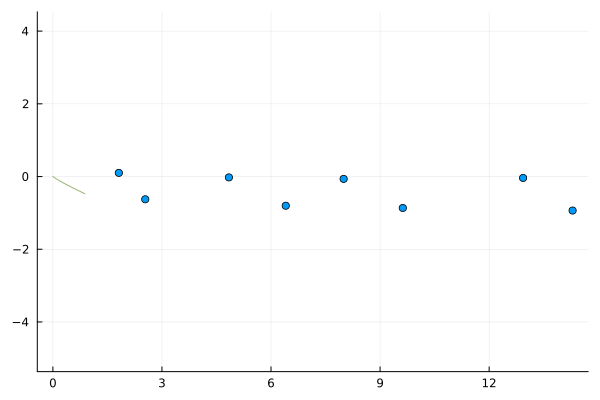

In [517]:
c   = 1.0;   # chord length

ċ   = -1.0;  # translational velocity
α̇   = 0.0;

motion = RigidBodyMotion(ċ, α̇);

σLE = 0.0; # LESP
σTE = 0.0; # TESP
δ   = 0.01; # blob radius

Δt        = 0.025;
tf        = 3.625;
sub_cycle = 10;
T         = 0.0:Δt:tf 

# Starting iteration of data
itr_start = 1

# Load in initial farfield conditions for the starting iteration
ξ   = ξ_hist[itr_start]
ω̄   = ω_hist[itr_start]
x̄   = x̄_hist[itr_start]
ȳ   = ȳ_hist[itr_start]
xb  = xb_hist[:,itr_start]
yb  = yb_hist[:,itr_start]

# drop NaNs from community data
ξ = ξ[ξ[:,3] .!= 0.0, :]


# get data from timestep of choice
X_partial = ξ[:,1];
Y_partial = ξ[:,2];
Γ_partial = ξ[:,3].*Δx^2;

# Load in the body for the starting iteration
b = b_list[1]


scatter(ξ[:,1], ξ[:,2])
plot!(b)

# Initilize the System
---

In [518]:
# initilize the system
init_ω_z = PotentialFlow.Vortex.Point.(X_partial .+ im.*Y_partial, Γ_partial)#, δ)
init_ω_ζ = inverse_conftransform(init_ω_z, b)

# ----------------------

sys = (b, init_ω_ζ)
sys₊ = deepcopy(sys) # Used for storage during time-marching

# Set up a velocity structure that will work for 4th-order Runge-Kutta
ẋs = [(motion, allocate_velocity(init_ω_ζ)) for k = 1:4];

# To keep track of time
t = 0.0
thist = Float64[]
append!(thist,t)

# To keep track of element trajectories
track = ComplexF64[]
append!(track,Elements.position(init_ω_z))

# To keep track of linear impulse
imp = ComplexF64[]
append!(imp,Elements.impulse((b,init_ω_z)));

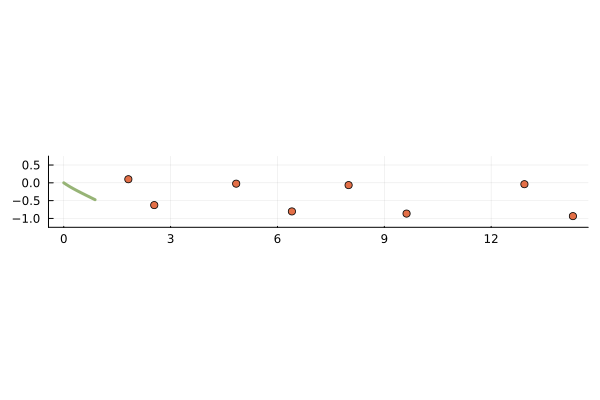

In [519]:
# Plot the initilized system
# preform coordinate transform
final_b, final_ω = sys;
ambient_ω_z = conftransform(final_ω, final_b);

plot(b, c = :black, linewidth = 3)
scatter!(real.((v->v.z).(ambient_ω_z)), imag.((v->v.z).(ambient_ω_z)))
plot!(ylim = (-1.25, 0.75))
p_save = plot!(aspect_ratio = :equal)

savefig(p_save,"./plots/potential_IC.png")

p_save

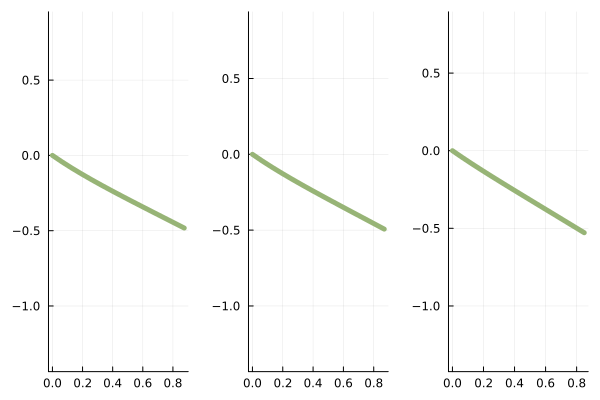

In [520]:
p1 = plot(b_list[10], color = :black, linewidth = 5)
p2 = plot(b_list[15], color = :black, linewidth = 5)
p3 = plot(b_list[30], color = :black, linewidth = 5)

plot(p1, p2, p3, layout = grid(1,3))

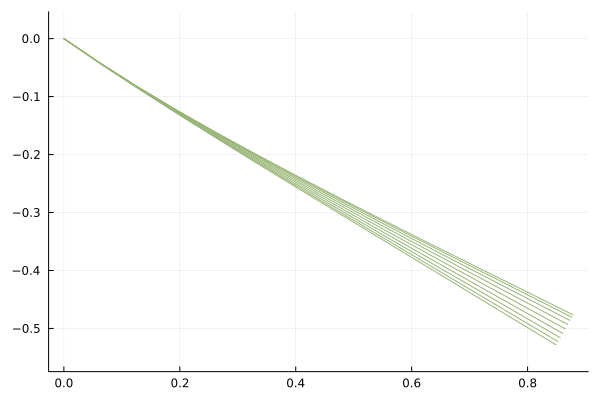

In [543]:
plot()

for i = 6:3:30
    plot!(b_list[i], color = :black, linewidth = 1)
end

plot!()

# Advance the Solution
---

In [522]:
i = 1
cycle = 1

ambient_ω_z_hist = []
b_hist = []
sys_hist = []

plot()

for ti ∈ T

    # ---------------------------------
    # Advect the farfield
    # ---------------------------------
    
    TimeMarching.rk4!(sys₊, sys, ti, Δt, compute_ẋ!, advect!, ẋs)
    
    sys₊, sys = sys, sys₊

    t += Δt
    b_now, ambient_ω_ζ = sys
    temp_ω_z = conftransform(ambient_ω_ζ,b_now)
    append!(thist,t)
    append!(track, Elements.position(temp_ω_z))
    append!(imp, Elements.impulse((b_now,temp_ω_z)))

    # ---------------------------------
    # Plot the results
    # ---------------------------------

    final_b, final_ω = sys
    ambient_ω_z = conftransform(final_ω, final_b)

    a = ambient_ω_z
    # scatter!(real.((v->v.z).(a)), imag.((v->v.z).(a)), c = :blue, alpha = 0.2)
    # plot!(real.(b.zs), imag.(b.zs), c = :black, linewidth = 1)
    # plot!(legend = :false, xlim = [-0.25, 2], ylim = [-1.5, 1.0], aspect_ratio = 1, dpi = 300)
    # savefig(joinpath("./plots/","evo_" * lpad(i,4,"0") * ".png"))

    push!(ambient_ω_z_hist, ambient_ω_z)
    push!(b_hist, b)
    
    # ---------------------------------
    # Move the body
    # ---------------------------------


    # Ideas
    # ---------------------------------
    # - Pause for one flow-through
    # - Subcyle between body movements
    # - * or / by dx or dxdy or π or 2π (check vortex strength) Δx = 0.12308
    # - Make sure not to run when about to shed vortex
    # - Artificially introduce new vortex (newly sheded vortex)
    # - Check normals x_body = x_lab?
    # - Is force in this "mapped" domain?
    # - Re number (velocity and length)
    
    
    # subcycles between body movements
    # if i%sub_cycle == 0

    #     cycle += 1 # we start at body[1]
    #     b = b_list[cycle]

    #     sys = (b, sys[2])
    # end

    push!(sys_hist, sys)

    # ---------------------------------

    i += 1

end

final_b, final_ω = sys;
ambient_ω_z      = conftransform(final_ω,final_b);
force            = -diff(imp)/Δt;

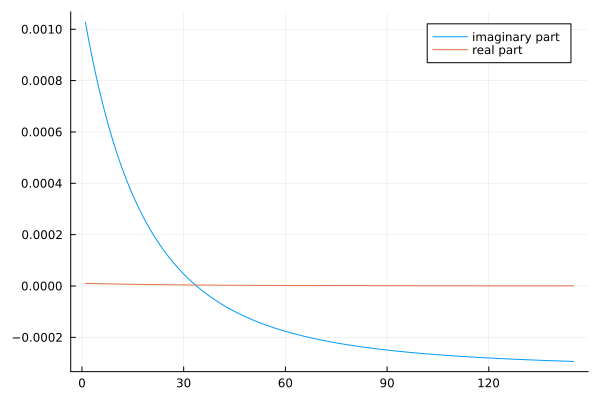

In [523]:
plot(imag.(force)[2:end], label = "imaginary part")
plot!(real.(force)[2:end], label = "real part")
# plot!(ylim = [-0.1, 0.1])

In [524]:
cycle

1

In [525]:
fieldnames(typeof(sys_hist[1][1]))

(:m, :minv, :dm, :c, :α, :zetas, :zs, :ċ, :α̇, :c̈, :α̈, :img)

# Plot the Solution
---

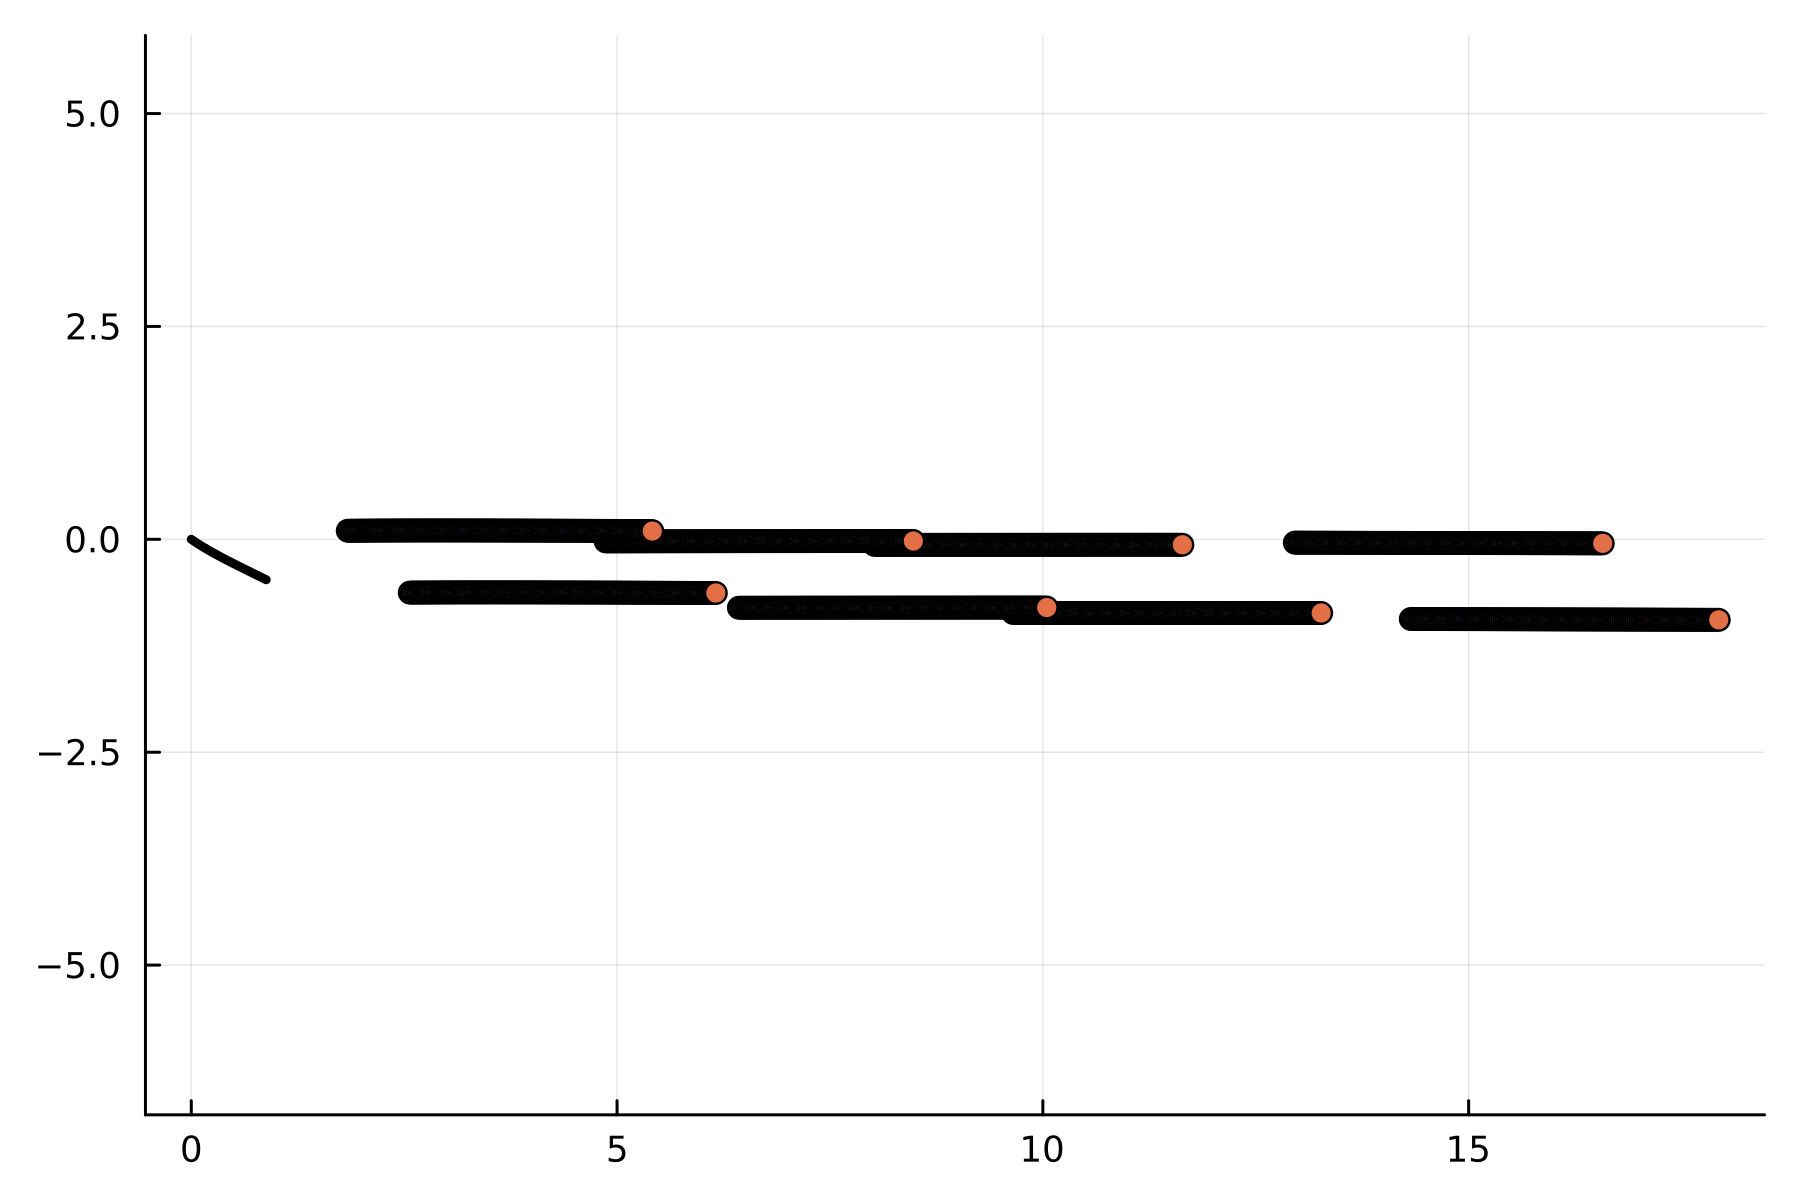

In [526]:
plot()

for i = 1:1:size(b_hist)[1]
    a = ambient_ω_z_hist[i]
    scatter!(real.((v->v.z).(a)) .-i*Δt*ċ, imag.((v->v.z).(a)), alpah = 0.2)
end

b = b_hist[end]
plot!(real.(b.zs) .-size(T)[1]*Δt*ċ, imag.(b.zs), c = :black, linewidth = 3)
plot!(aspect_ratio = :equal, legend = :false,)

# # Plot the Community Detection data
# # ---------------------------------------

# for itr = itr_start:1:(itr_start + size(T)[1])

#     ξ   = ξ_hist[itr]
#     ω̄   = ω_hist[itr]
#     x̄   = x̄_hist[itr]
#     ȳ   = ȳ_hist[itr]
#     xb  = xb_hist[:,itr]
#     yb  = yb_hist[:,itr]

#     # drop NaNs from community data
#     ξ = ξ[ξ[:,3] .!= 0.0, :]

#     # # drop far away communities
#     # ξ = ξ[ξ[:,1] .< 10.0, :]

#     # get data from timestep of choice
#     X_partial = ξ[:,1];
#     Y_partial = ξ[:,2];
#     Γ_partial = ξ[:,3];

#     scatter!(X_partial, Y_partial, markersize = 2, c = :pink)
# end


p_save = plot!(legend = :false, aspectratio = :equal, dpi = 300)


savefig(p_save,"./plots/potential_advance.png")

p_save

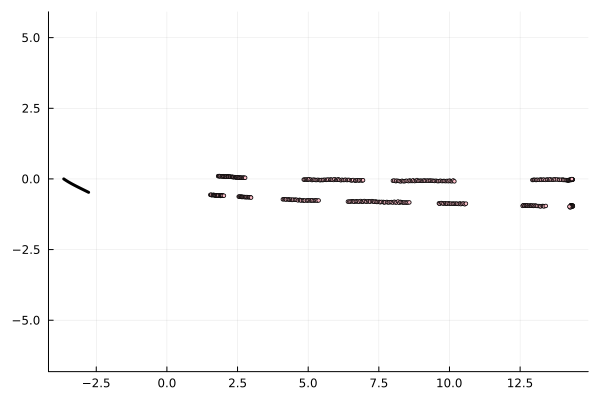

In [527]:
plot()

#len = (size(ξ_hist)[1])
len = 50

for itr = 1:1:len

    ξ   = ξ_hist[itr]
    ω̄   = ω_hist[itr]
    x̄   = x̄_hist[itr]
    ȳ   = ȳ_hist[itr]
    xb  = xb_hist[:,itr]
    yb  = yb_hist[:,itr]

    # drop NaNs from community data
    ξ = ξ[ξ[:,3] .!= 0.0, :]

    # get data from timestep of choice
    X_partial = ξ[:,1];
    Y_partial = ξ[:,2];
    Γ_partial = ξ[:,3];

    scatter!(X_partial, Y_partial, markersize = 2, c = :pink)
end

plot!(real.(b.zs), imag.(b.zs), c = :black, linewidth = 3)
p_save = plot!(legend = :false, aspect_ratio = :equal)

savefig(p_save,"./plots/community_traces.png")

p_save

In [528]:
len*Δt*20*ċ

-25.0

In [529]:
Δt = 0.025

size(ξ_hist)[1]*Δt

3.625

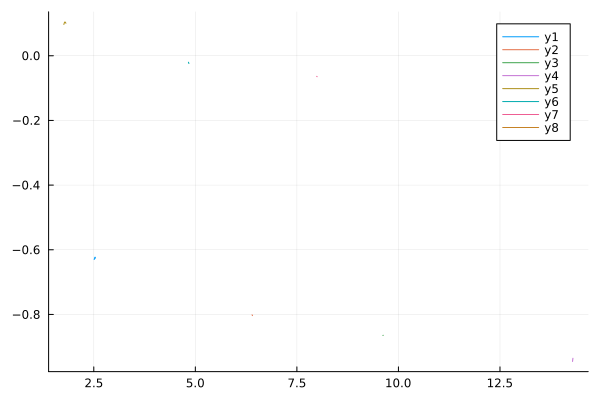

In [530]:
plot()

for i = 1:length(init_ω_z)
    plot!(real.(track[i:length(init_ω_z):end]), imag.(track[i:length(init_ω_z):end]));
end
plot!()

In [531]:
T

0.0:0.025:3.625

In [532]:
size(T)

(146,)

In [533]:
Δt = 0.0025
i_save = 20
i_stop = 100_000

T2 = range(0, i_stop*Δt, size(force_hist)[1])

UndefVarError: UndefVarError: force_hist not defined

In [534]:
t_start = 180

plot(T .+ t_start, real.(force), label = "drag - potential flow", linestyle = :dash, c =:red)
plot!(T .+ t_start, imag.(force), label = "lift - potential flow", linestyle = :dash, c =:blue)
plot!(ylim = [0, 1.25])
plot!(T2[:], force_hist[:, 2], label = "drag - IBPM", c =:red)
plot!(T2[:], force_hist[:, 3], label = "lift - IBPM",c =:blue)
# plot!([375/2; 375/2], [0.0; 10.0], label = "gust", c = :black, linewidth = 2, linestyle = :dash)
plot!(ylabel = "Force [N/m]", xlabel = "Time [s]", dpi = 300, xlim = [t_start, (t_start + tf)],ylim = [0, 1.25], legend = :right)

savefig("force_short_limit.png")

plot!()

UndefVarError: UndefVarError: T2 not defined

In [535]:
plot(T2[70000:80000], force_hist[70000:80000, 2], label = "drag", c = :red)
plot!(T2[70000:80000], force_hist[70000:80000, 3], label = "lift", c = :blue)
plot!([375/2; 375/2], [0.0; 10.0], label = "gust", c = :black, linewidth = 2, linestyle = :dash)
plot!(ylim = [0, 1.25], ylabel = "Force [N/m]", xlabel = "Time [s]", dpi = 300, xlim = [175, 200])

savefig("force_long.png")

plot!()

UndefVarError: UndefVarError: T2 not defined

----

In [536]:
# Load in the precomputed community detection data
# -----------------------------------------
fileIn = matopen("./comm_hist_a35_g00_k0625_mg5_limit_new.mat")

# ξ_hist  = d["xi_hist"];
# xb_hist = d["xb"];
# yb_hist = d["yb"];
# x̄_hist  = d["x_bar_hist"];
# ȳ_hist  = d["y_bar_hist"];
# ω_hist  = d["omg_hist"];



ξ_hist = read(fileIn, "xi_hist") 
x̄_hist = read(fileIn, "x_bar_hist") 
ȳ_hist = read(fileIn, "y_bar_hist") 
xb_hist = read(fileIn, "xb") 
yb_hist = read(fileIn, "yb") 
ω_hist  = read(fileIn, "omg_hist");

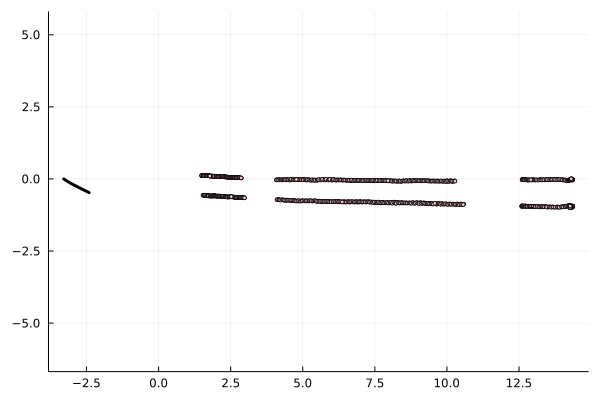

In [537]:
plot()
for itr = 1:1:(size(ξ_hist)[1])

    ξ   = ξ_hist[itr]
    ω̄   = ω_hist[itr]
    x̄   = x̄_hist[itr]
    ȳ   = ȳ_hist[itr]
    xb  = xb_hist[:,itr]
    yb  = yb_hist[:,itr]

    # drop NaNs from community data
    ξ = ξ[ξ[:,3] .!= 0.0, :]

    # get data from timestep of choice
    X_partial = ξ[:,1];
    Y_partial = ξ[:,2];
    Γ_partial = ξ[:,3];

    scatter!(X_partial, Y_partial, markersize = 2, c = :pink)
end

plot!(real.(b.zs).-size(ξ_hist)[1]*Δt*ċ, imag.(b.zs), c = :black, linewidth = 3)
plot!(legend = :false, aspect_ratio = :equal)



In [538]:
ξ_hist[1]

8×3 Matrix{Float64}:
  2.54096  -0.625904    4.44857
  6.4057   -0.803419    1.64697
  9.62495  -0.86439     1.49437
 14.2958   -0.935433    2.44546
  1.8135    0.100471   -4.1201
  4.84163  -0.0241327  -1.72221
  7.99767  -0.0648019  -1.54953
 12.9339   -0.0390146  -2.66477

In [539]:
ξ_hist[2]

8×3 Matrix{Float64}:
  2.56582  -0.626714    4.48436
  6.45473  -0.801418    1.64393
  9.65192  -0.880769    1.48857
 14.2926   -0.932112    2.416
  1.8248    0.0960754  -4.14998
  4.87581  -0.0249721  -1.7238
  8.04275  -0.0577804  -1.54507
 12.9732   -0.0353389  -2.64728